In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import pandas as pd

In [2]:
date = '20150121' # yyyymmdd datum
run  = '12'       # tijd run (00,06,12,18)

baseurl = "http://nomads.ncep.noaa.gov:9090/dods/gens/gens%s/gep_all_%sz" % (date, run)
uwindurl = "?ugrdprs[0:20][0:64][25][150][0:359]"
toturl = baseurl + uwindurl

data = Dataset(toturl)

lons_1p00 = np.arange(360)
times_6h = pd.date_range(start = '%s %s'%(date,run), periods = 65, freq='6H')
members = np.arange(21)

u_gens = pd.Panel(data.variables["ugrdprs"][:].squeeze(), items = members, major_axis = times_6h, minor_axis = lons_1p00)

In [3]:
baseurl2 = "http://nomads.ncep.noaa.gov:9090/dods/gfs_0p50/gfs%s/gfs_0p50_%sz" % (date, run)
uwindurl2 = "?ugrdprs[0:80][41][300][0:719]"
toturl2 = baseurl2 + uwindurl2

data2 = Dataset(toturl2)

times_3h_para = pd.date_range(start = '%s %s'%(date,run), periods = 81, freq='3H')
lons_0p50 = np.arange(0,360,.5)

u_para = pd.DataFrame(data2.variables["ugrdprs"][:].squeeze(), index = times_3h_para, columns = lons_0p50)

In [4]:
u_para_mean = pd.DataFrame(np.trapz(u_para, u_para.columns, axis = 1) / 360., index = u_para.index)
#u_gfshd_mean = pd.DataFrame(np.trapz(u_gfshd, u_gfshd.columns, axis = 1) / 360., index = u_gfshd.index)
u_gens_mean = pd.DataFrame(np.trapz(u_gens, u_gens.minor_axis, axis = 2).T / 360., index = u_gens.major_axis)
u_gens_mean_mean = u_gens_mean.mean(axis = 1)

In [5]:
u = pd.concat([u_para_mean, u_gens_mean_mean, u_gens_mean], axis = 1)

u.columns = ['Oper','Ensemble Mean','Control'] + range(20)

u.interpolate(method = 'time', limit = 1, inplace=True)

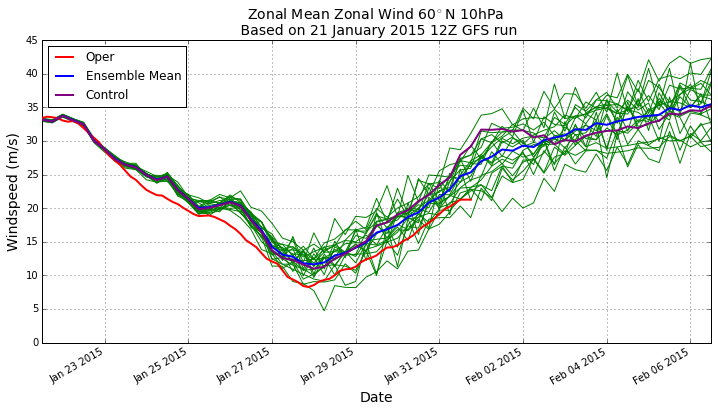

In [6]:
fig, ax  = plt.subplots(figsize=(12,6))

member_colors = ['green']*20
member_linewidth = [2,2,2] + list(np.ones(20))

u.iloc[:,:3].plot(ax = ax, color = ['red','blue', 'purple'], linewidth = 2, zorder = 3)
u.iloc[:,3:].plot(ax = ax, color = member_colors, linewidth = 1, legend = False)


ax.plot([times_6h[0],times_6h[-1]],[0,0], color = 'k', zorder = -1)
ax.set_xlabel('Date', fontsize = 14)
ax.set_ylabel('Windspeed (m/s)', fontsize = 14)
ax.set_title('Zonal Mean Zonal Wind 60$^{\circ}$N 10hPa \n Based on %s GFS run'%(times_6h[0].strftime('%d %B %Y %HZ')),fontsize=14)

plt.savefig('F:\\Afbeeldingen\\Ensembleverwachtingen\\GFSzonalwind_%s_GFS%sZ.png'\
          %(date,run),bbox_inches='tight')